In [1]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [2]:
# Importation des bibliothèques nécessaires

# Traitement des données
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Modèles statistiques
import statsmodels.api as sm


# Deep learning
import tensorflow as tf

# Outils utiles
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score







In [3]:
# Charger les données
df = pd.read_csv("dataset.csv")


# Aperçu général
print("Aperçu du dataset :")
print(df.head())

print("\nInformations sur les colonnes :")
print(df.info())

print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())


# Affichage de nombre de doublons

nb_doublons = df.duplicated().sum()
print(f"Nombre de doublons dans le dataset : {nb_doublons}")

# Conversion des dates
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

# Statistiques descriptives de la variable 'value'
df['value'] = pd.to_numeric(df['value'], errors='coerce')
print("\nStatistiques descriptives de 'value' (CO₂) :")
print(df['value'].describe())



Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Affichage du nombre de valeurs aberrantes
outliers = df[(df['value'] < lower_bound) | (df['value'] > upper_bound)]
print(f"Nombre de valeurs aberrantes détectées : {len(outliers)}")

Aperçu du dataset :
     country        date sector      value   timestamp
0     Brazil  01/01/2019  Power   0.096799  1546300800
1      China  01/01/2019  Power  14.816100  1546300800
2  EU27 & UK  01/01/2019  Power   1.886490  1546300800
3     France  01/01/2019  Power   0.051217  1546300800
4    Germany  01/01/2019  Power   0.315002  1546300800

Informations sur les colonnes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135408 entries, 0 to 135407
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   country    135408 non-null  object 
 1   date       135408 non-null  object 
 2   sector     135408 non-null  object 
 3   value      135408 non-null  float64
 4   timestamp  135408 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 5.2+ MB
None

Valeurs manquantes par colonne :
country      0
date         0
sector       0
value        0
timestamp    0
dtype: int64
Nombre de doublons dans le data

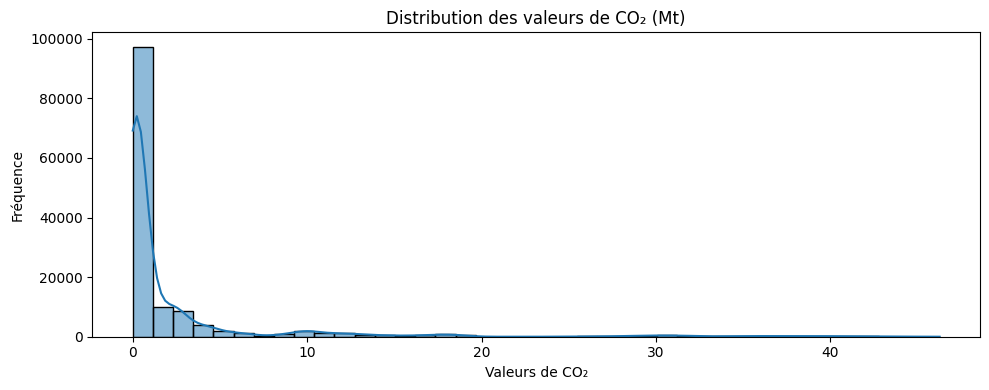

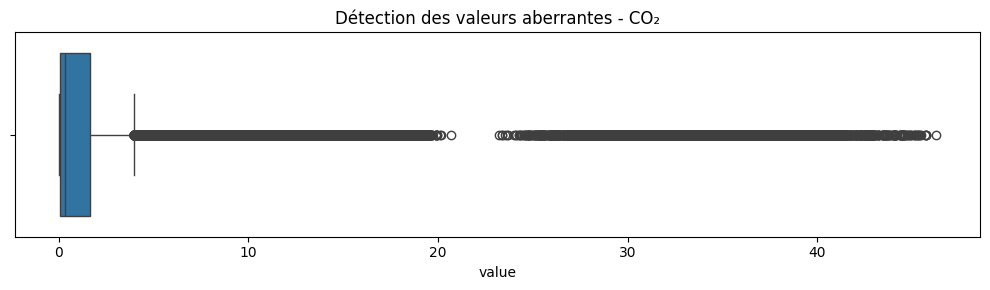

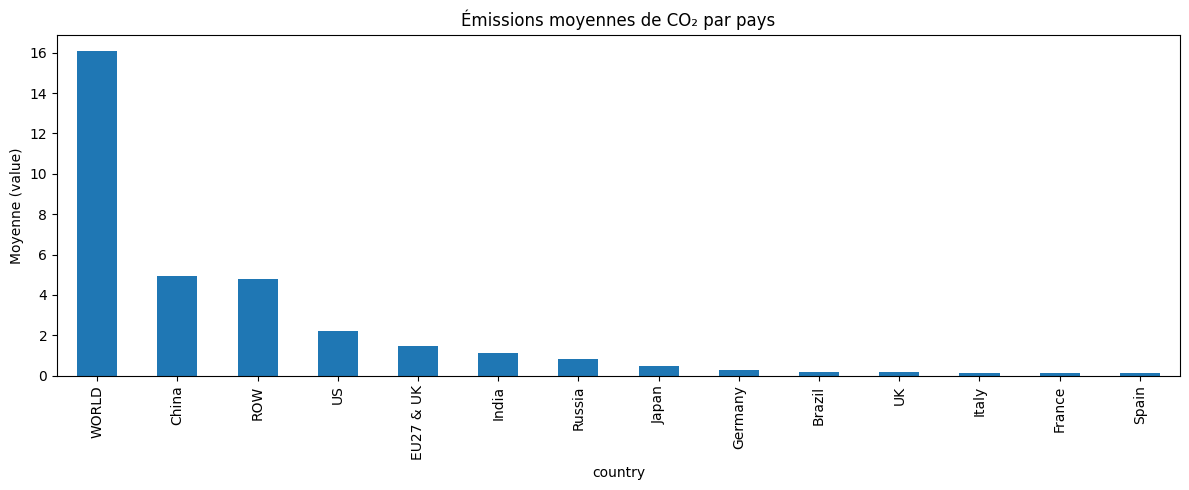

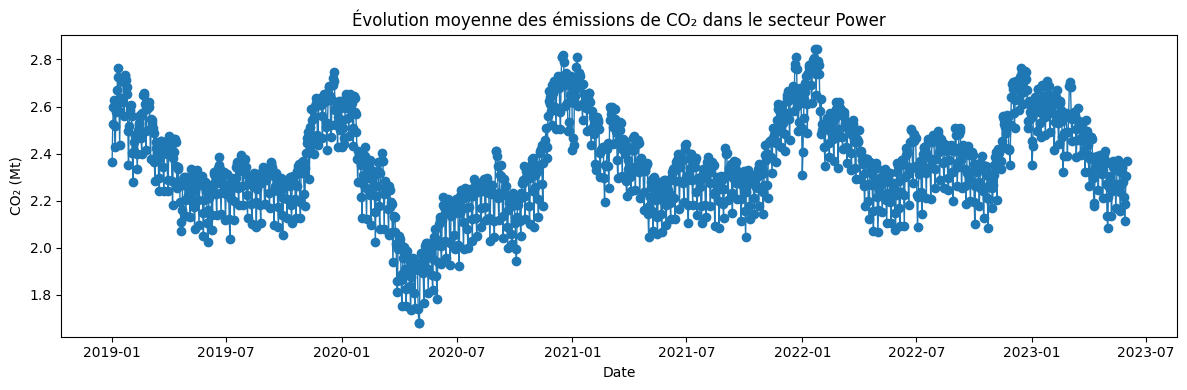

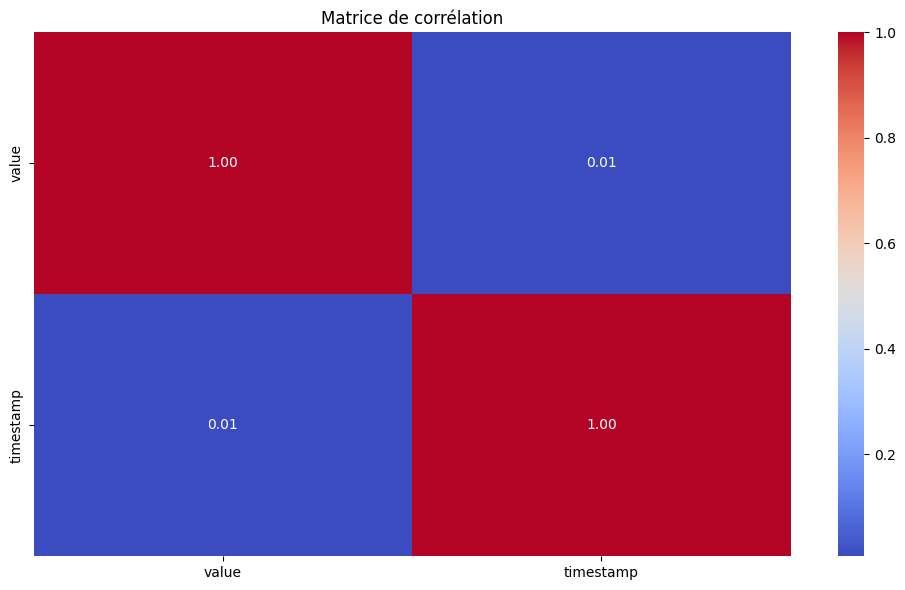

In [ ]:
# Distribution de CO₂
plt.figure(figsize=(10, 4))
sns.histplot(df['value'], kde=True, bins=40)
plt.title("Distribution des valeurs de CO₂ (Mt)")
plt.xlabel("Valeurs de CO₂")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

# Boxplot pour détecter les valeurs aberrantes
plt.figure(figsize=(10, 3))
sns.boxplot(x=df['value'])
plt.title("Détection des valeurs aberrantes - CO₂")
plt.tight_layout()
plt.show()

#  Émissions moyennes par pays
plt.figure(figsize=(12, 5))
df.groupby('country')['value'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title("Émissions moyennes de CO₂ par pays")
plt.ylabel("Moyenne (value)")
plt.tight_layout()
plt.show()

# Évolution du CO₂ dans le temps (moyenne globale)
df_time = df.groupby('date')['value'].mean().reset_index()

plt.figure(figsize=(12, 4))
plt.plot(df_time['date'], df_time['value'], marker='o', linewidth=1)
plt.title("Évolution moyenne des émissions de CO₂ dans le secteur Power")
plt.xlabel("Date")
plt.ylabel("CO₂ (Mt)")
plt.tight_layout()
plt.show()

# Corrélation entre les colonnes numériques
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation")
plt.tight_layout()
plt.show()



In [4]:

from sklearn.preprocessing import MinMaxScaler

# Encodage des colonnes catégorielles
df = pd.get_dummies(df, columns=['country', 'sector'], drop_first=True)

# Tri chronologique
df.sort_values('date', inplace=True)

# Normalisation des valeurs
scaler = MinMaxScaler()
df['value_scaled'] = scaler.fit_transform(df[['value']])

# Remplacement des outliers par la médiane
df.loc[(df['value'] < lower_bound) | (df['value'] > upper_bound), 'value'] = df['value'].median()

# Extraction de l’année
df['year'] = df['date'].dt.year

# Extraction du mois
df['month'] = df['date'].dt.month

# Extraction du trimestre
df['quarter'] = df['date'].dt.quarter

# Sauvegarde du dataset
df.to_csv("dataset_preprocessed.csv", index=False)
print("Dataset prétraité sauvegardé sous 'dataset_preprocessed.csv'")



Dataset prétraité sauvegardé sous 'dataset_preprocessed.csv'


In [13]:

# Chargement du dataset
df = pd.read_csv("dataset_preprocessed.csv", parse_dates=['date'])

# Moyenne mensuelle des émissions CO₂
df_monthly = df.resample('ME', on='date')['value'].mean().reset_index()

# Affichage des premières lignes
print(df_monthly.head())


        date     value
0 2019-01-31  0.657888
1 2019-02-28  0.648993
2 2019-03-31  0.647079
3 2019-04-30  0.613108
4 2019-05-31  0.564592


In [22]:
from sklearn.model_selection import TimeSeriesSplit

# Découpage pour validation croisée sur tout df_monthly
tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_idx, val_idx) in enumerate(tscv.split(df_monthly)):
    train_fold = df_monthly.iloc[train_idx]
    val_fold = df_monthly.iloc[val_idx]

<ipython-input-21-d8fea078a4c6>:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M', on='date')['value'].mean().reset_index()


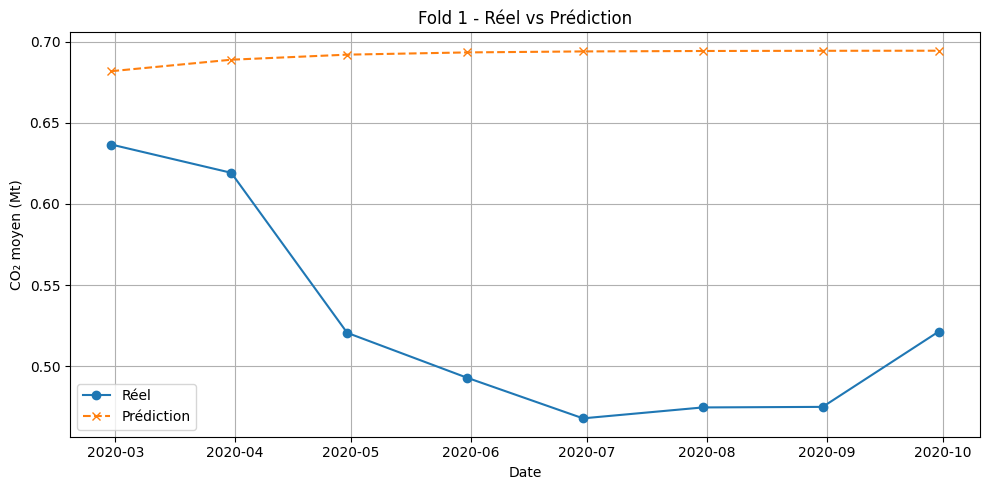

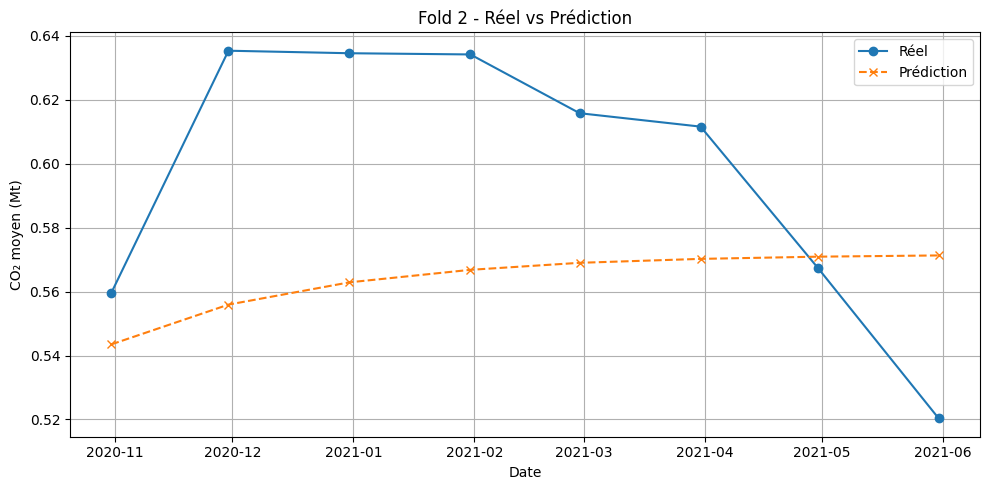

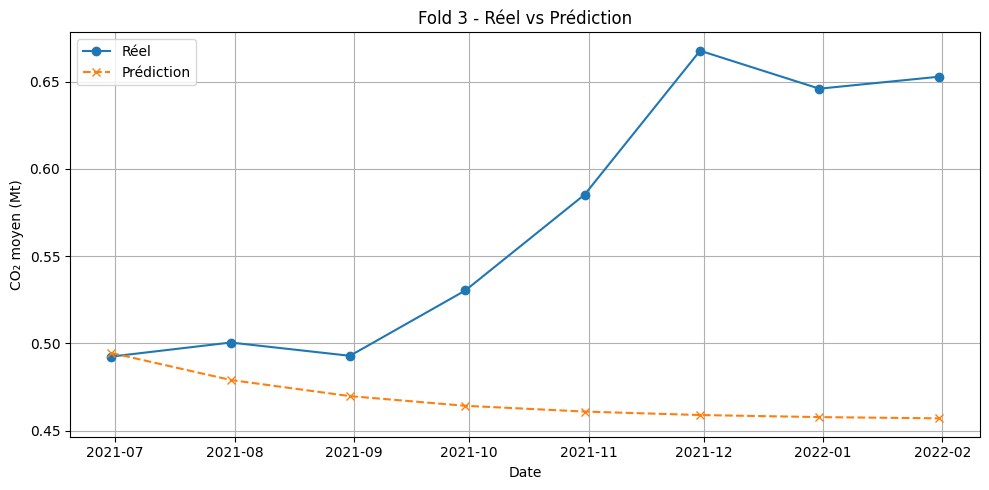

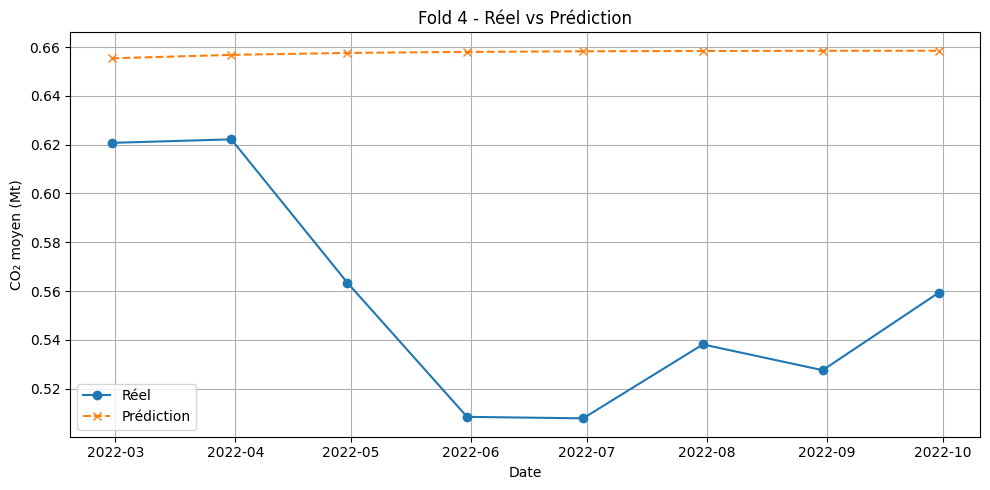

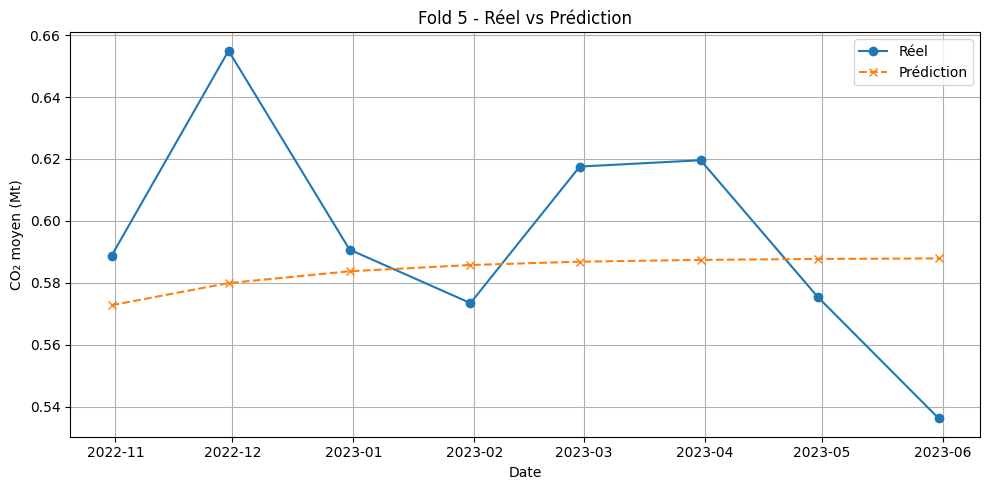


 Résumé des performances :
           MSE      RMSE       MAE        R2
Fold                                        
1     0.031760  0.178214  0.165676 -7.275337
2     0.002843  0.053320  0.047136 -0.754181
3     0.017273  0.131427  0.103737 -2.389163
4     0.012206  0.110479  0.101693 -5.810229
5     0.001362  0.036899  0.029651 -0.200552

 Moyennes :
MSE     0.013089
RMSE    0.102068
MAE     0.089579
R2     -3.285892
dtype: float64


In [21]:
# Modèle ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

# Fonctions
def train_arima(y_train, order):
    model = sm.tsa.ARIMA(y_train, order=order)
    return model.fit()

def forecast(model_fit, steps):
    return model_fit.forecast(steps=steps)

def compute_metrics(y_true, y_pred):
    return {
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

def plot_predictions(dates, y_true, y_pred, fold):
    plt.figure(figsize=(10, 5))
    plt.plot(dates, y_true, label="Réel", marker='o')
    plt.plot(dates, y_pred, label="Prédiction", linestyle='--', marker='x')
    plt.title(f"Fold {fold} - Réel vs Prédiction")
    plt.xlabel("Date")
    plt.ylabel("CO₂ moyen (Mt)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

#  Chargement des données
df = pd.read_csv("dataset_preprocessed.csv", parse_dates=['date'])
df_monthly = df.resample('M', on='date')['value'].mean().reset_index()

#  Paramètres
n_splits = 5
order = (1, 1, 1)

#  Validation croisée
tscv = TimeSeriesSplit(n_splits=n_splits)
results = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(df_monthly), 1):
    train = df_monthly.iloc[train_idx]
    val = df_monthly.iloc[val_idx]

    y_train, y_val = train['value'], val['value']

    try:
        model_fit = train_arima(y_train, order)
        y_pred = forecast(model_fit, len(y_val))
        metrics = compute_metrics(y_val, y_pred)
        metrics['Fold'] = fold
        results.append(metrics)
        plot_predictions(val['date'], y_val, y_pred, fold)

    except Exception as e:
        print(f"Erreur au fold {fold}: {e}")

#  Résultats
df_results = pd.DataFrame(results).set_index('Fold')

print("\n Résumé des performances :")
print(df_results)

print("\n Moyennes :")
print(df_results.mean())

df_arima = df_results.copy()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/mlemodel.py:1235: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /


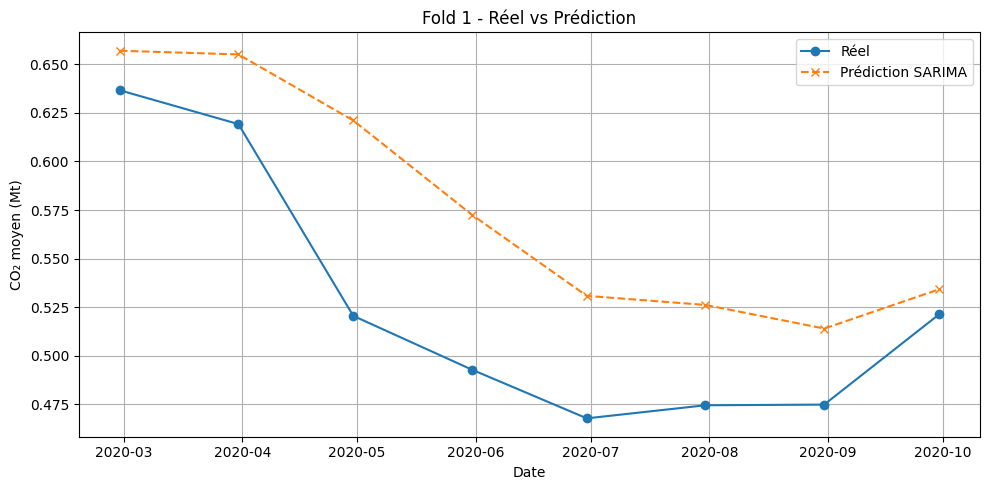

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


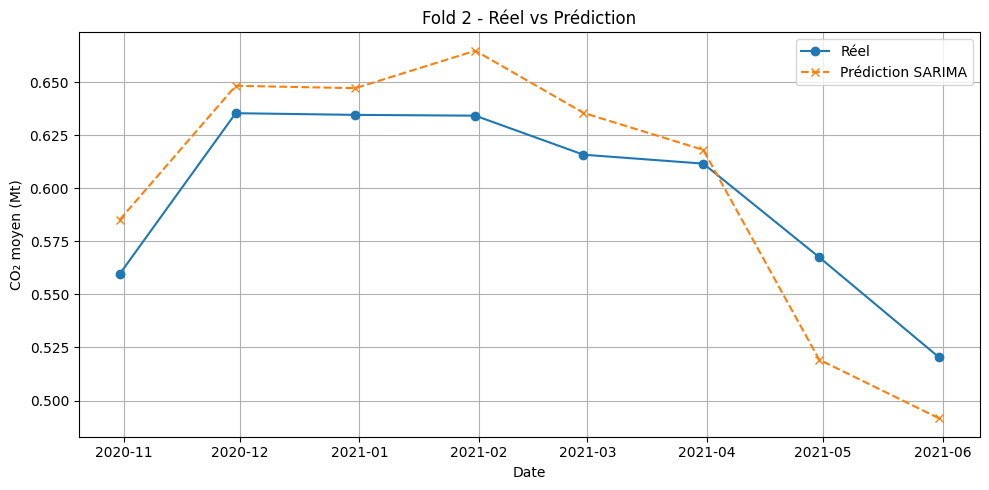

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


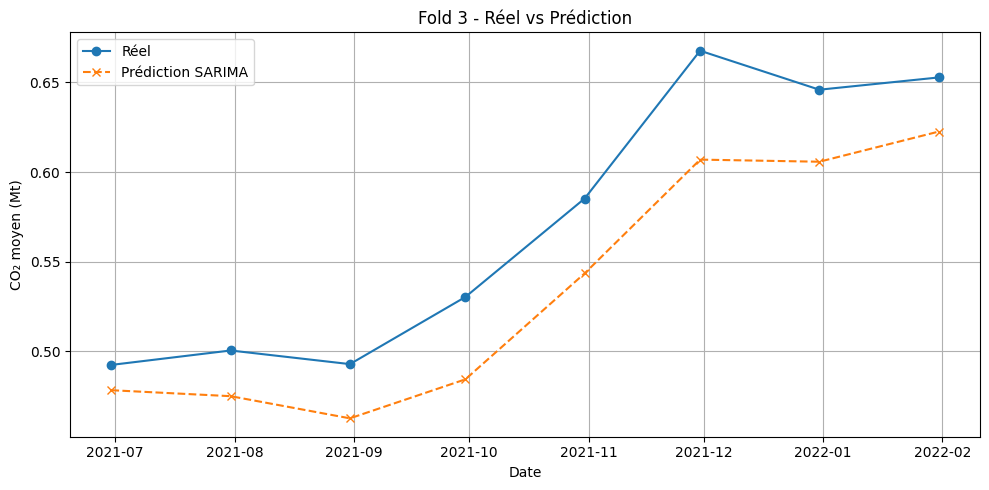

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


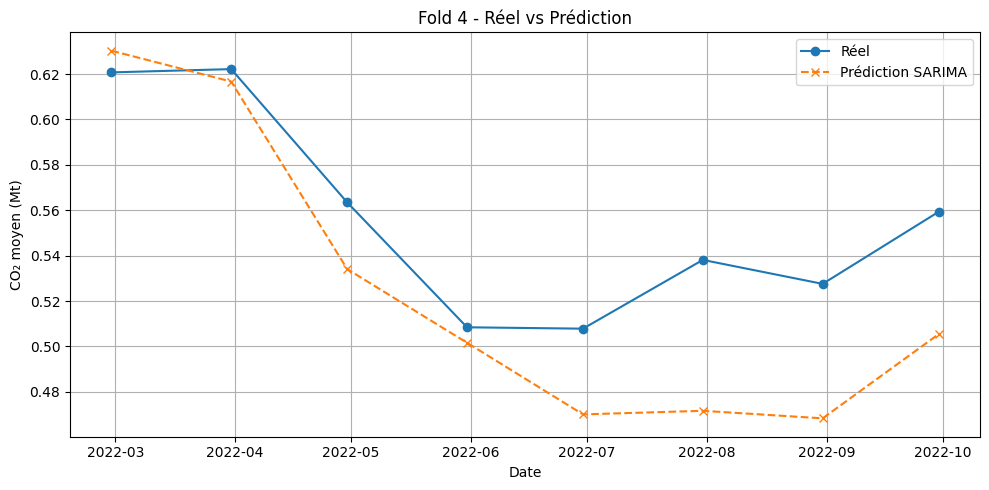

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


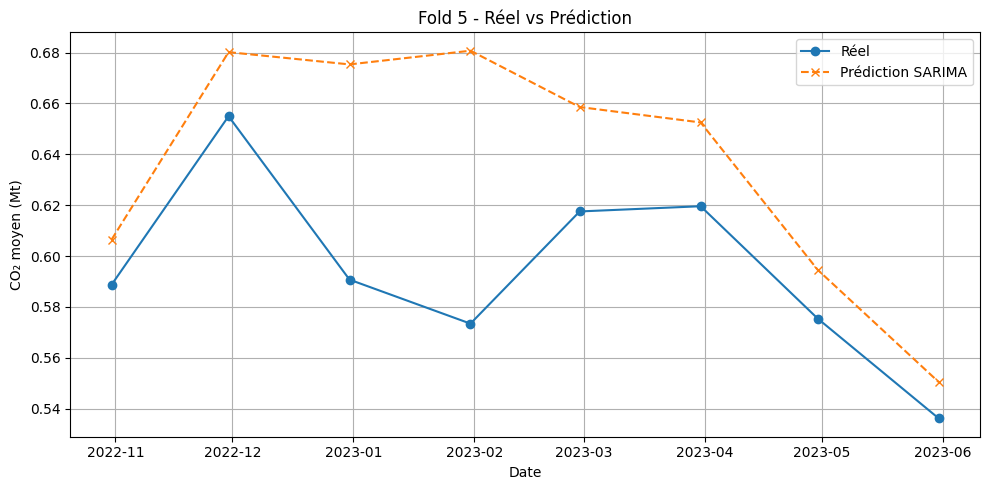


 Résumé des performances :
           MSE      RMSE       MAE        R2
Fold                                        
1     0.003309  0.057525  0.050369  0.137795
2     0.000686  0.026198  0.023083  0.576542
3     0.001480  0.038465  0.036087  0.709695
4     0.001660  0.040745  0.033565  0.073699
5     0.002871  0.053579  0.042786 -1.531249

 Moyennes :
MSE     0.002001
RMSE    0.043302
MAE     0.037178
R2     -0.006704
dtype: float64


In [24]:
# Modèle SARIMA

#  Fonctions
def train_sarima(y_train, order, seasonal_order):
    model = sm.tsa.SARIMAX(y_train, order=order, seasonal_order=seasonal_order)
    return model.fit()

def forecast(model_fit, steps):
    return model_fit.forecast(steps=steps)

def compute_metrics(y_true, y_pred):
    return {
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

def plot_predictions(dates, y_true, y_pred, fold):
    plt.figure(figsize=(10, 5))
    plt.plot(dates, y_true, label="Réel", marker='o')
    plt.plot(dates, y_pred, label="Prédiction SARIMA", linestyle='--', marker='x')
    plt.title(f"Fold {fold} - Réel vs Prédiction")
    plt.xlabel("Date")
    plt.ylabel("CO₂ moyen (Mt)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

#  Chargement des données
df = pd.read_csv("dataset_preprocessed.csv", parse_dates=['date'])
df_monthly = df.resample('ME', on='date')['value'].mean().reset_index()

#  Paramètres
n_splits = 5
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

#  Validation croisée
tscv = TimeSeriesSplit(n_splits=n_splits)
results = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(df_monthly), 1):
    train = df_monthly.iloc[train_idx]
    val = df_monthly.iloc[val_idx]

    y_train, y_val = train['value'], val['value']

    try:
        model_fit = train_sarima(y_train, order, seasonal_order)
        y_pred = forecast(model_fit, len(y_val))
        metrics = compute_metrics(y_val, y_pred)
        metrics['Fold'] = fold
        results.append(metrics)
        plot_predictions(val['date'], y_val, y_pred, fold)

    except Exception as e:
        print(f"Erreur au fold {fold}: {e}")

# Résultats
df_results = pd.DataFrame(results).set_index('Fold')

print("\n Résumé des performances :")
print(df_results)

print("\n Moyennes :")
print(df_results.mean())


df_sarima = df_results.copy()


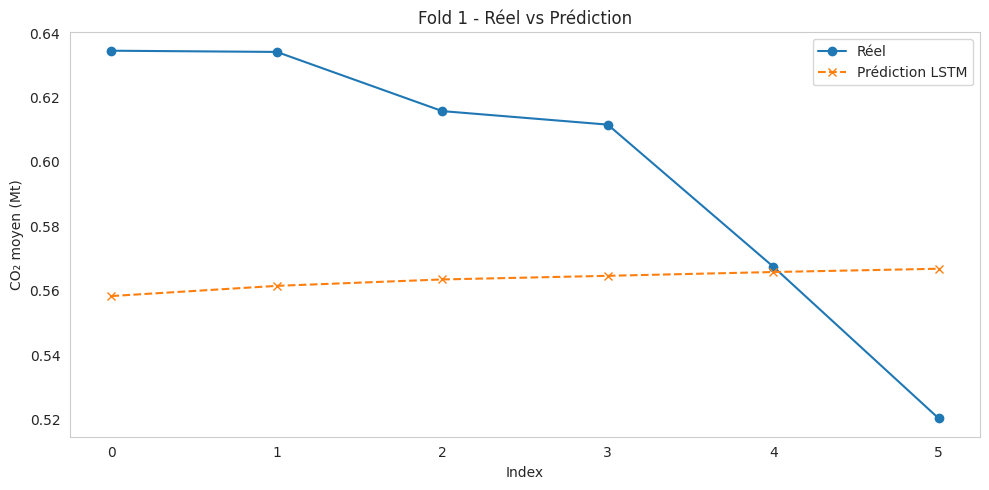

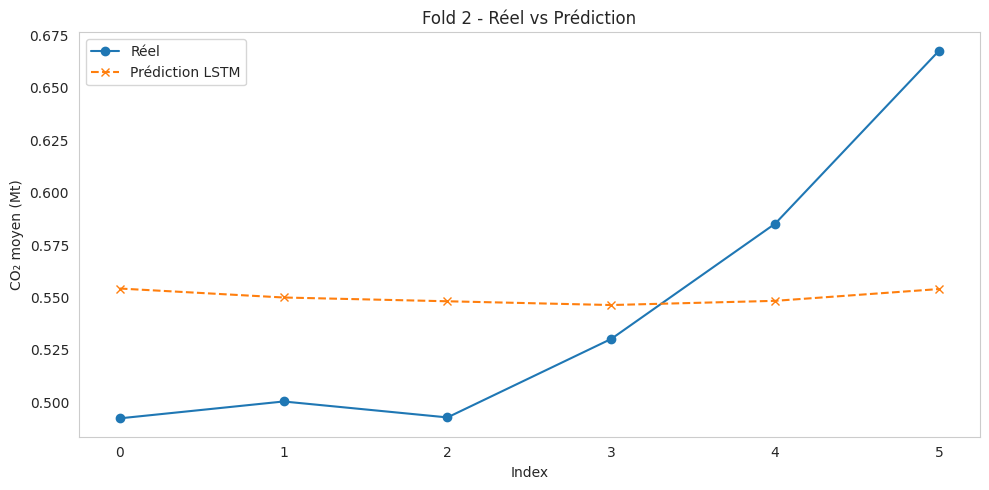

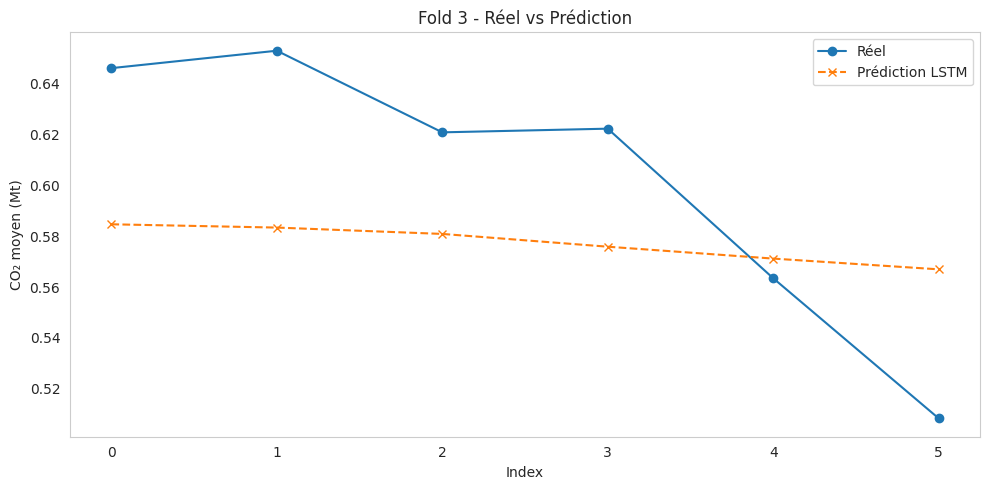

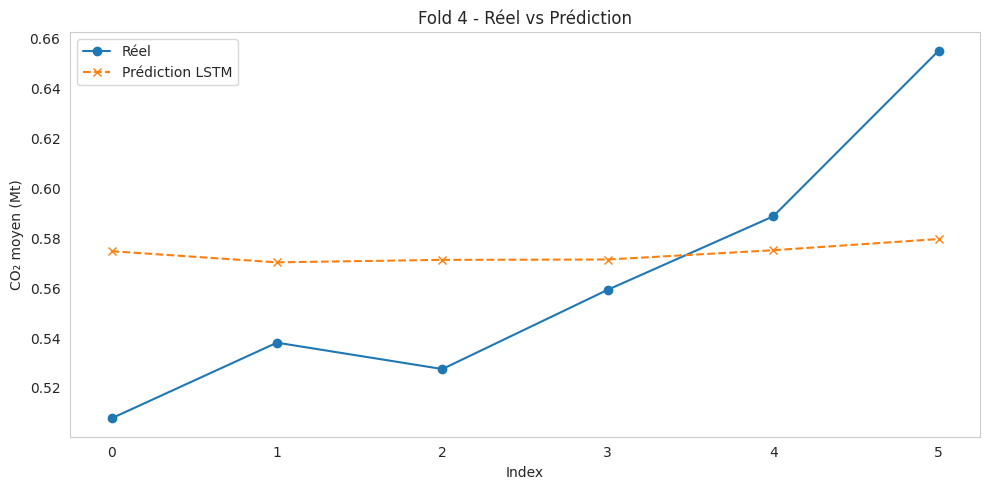

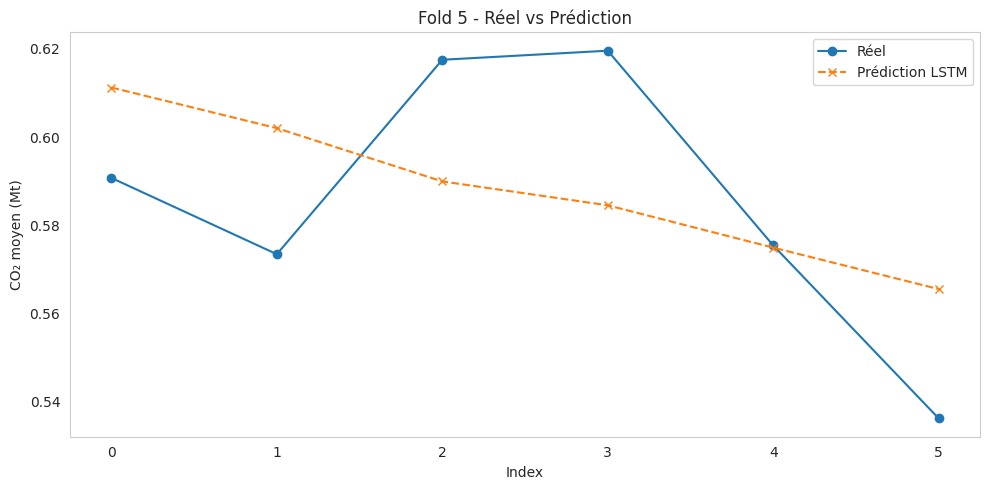


 Résumé des performances :
           MSE      RMSE       MAE        R2
Fold                                        
1     0.003031  0.055057  0.049377 -0.800556
2     0.003981  0.063091  0.055570  0.019533
3     0.002632  0.051304  0.047185 -0.019059
4     0.002238  0.047308  0.040628  0.044115
5     0.000682  0.026108  0.023601  0.164373

 Moyennes :
MSE     0.002513
RMSE    0.048574
MAE     0.043272
R2     -0.118319
dtype: float64


In [32]:
#Modèle LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Fonctions
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i + seq_length])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def compute_metrics(y_true, y_pred):
    return {
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

def plot_predictions(y_true, y_pred, fold):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label="Réel", marker='o')
    plt.plot(y_pred, label="Prédiction LSTM", linestyle='--', marker='x')
    plt.title(f"Fold {fold} - Réel vs Prédiction")
    plt.xlabel("Index")
    plt.ylabel("CO₂ moyen (Mt)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

#  Chargerement et préparation des données
df = pd.read_csv("dataset_preprocessed.csv", parse_dates=['date'])
df_monthly = df.resample('M', on='date')['value'].mean().reset_index()

scaler = MinMaxScaler()
df_monthly['value_scaled'] = scaler.fit_transform(df_monthly[['value']])

SEQ_LENGTH = 12
X, y = create_sequences(df_monthly['value_scaled'].values, SEQ_LENGTH)

#  Validation croisée
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
results = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    X_train = np.expand_dims(X_train, axis=-1)
    X_val = np.expand_dims(X_val, axis=-1)

    try:
        model = build_lstm_model((SEQ_LENGTH, 1))
        model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

        y_pred = model.predict(X_val, verbose=0).flatten()

 # Inversement de la normalisation
        y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
        y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

        metrics = compute_metrics(y_val_inv, y_pred_inv)
        metrics['Fold'] = fold
        results.append(metrics)

        plot_predictions(y_val_inv, y_pred_inv, fold)

    except Exception as e:
        print(f"Erreur au fold {fold}: {e}")

#  Résultats
df_results = pd.DataFrame(results).set_index('Fold')

print("\n Résumé des performances :")
print(df_results)

print("\n Moyennes :")
print(df_results.mean())


df_lstm = df_results.copy()


<ipython-input-26-e6b71337609d>:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M', on='date')['value'].mean().reset_index()


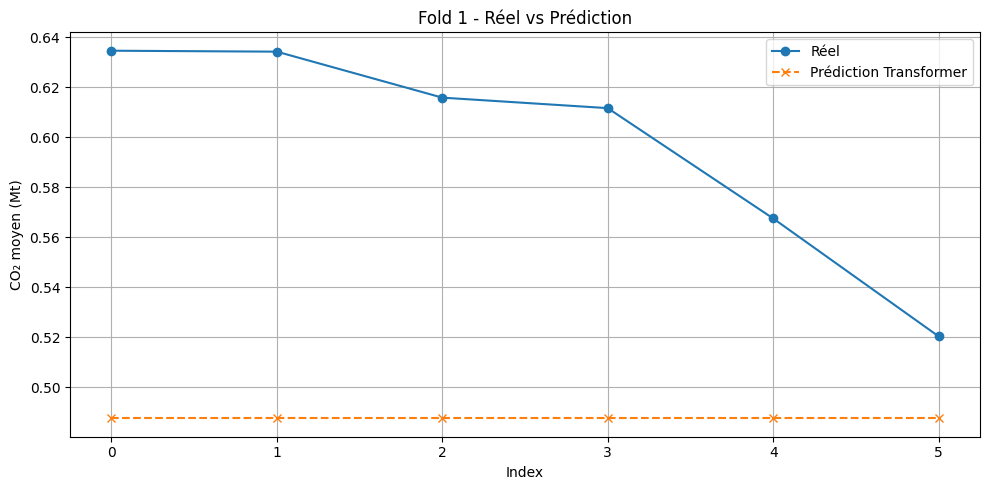

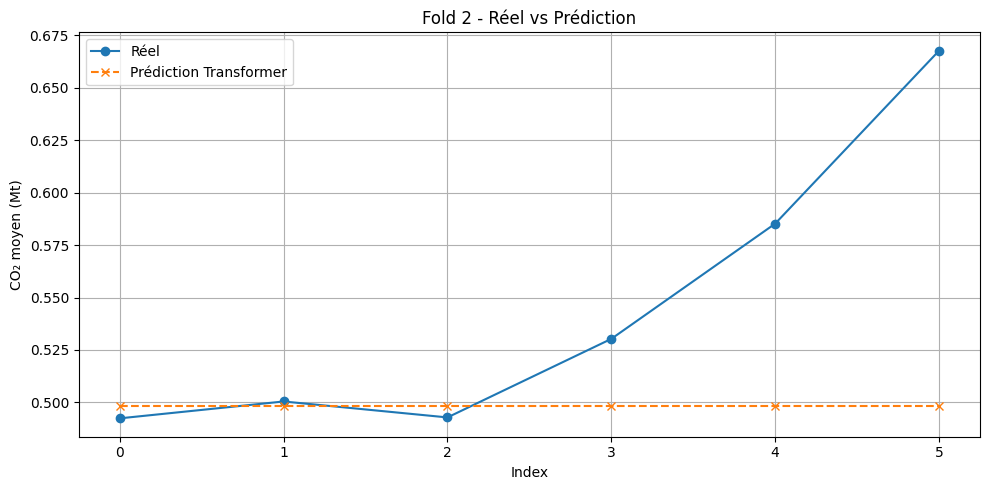

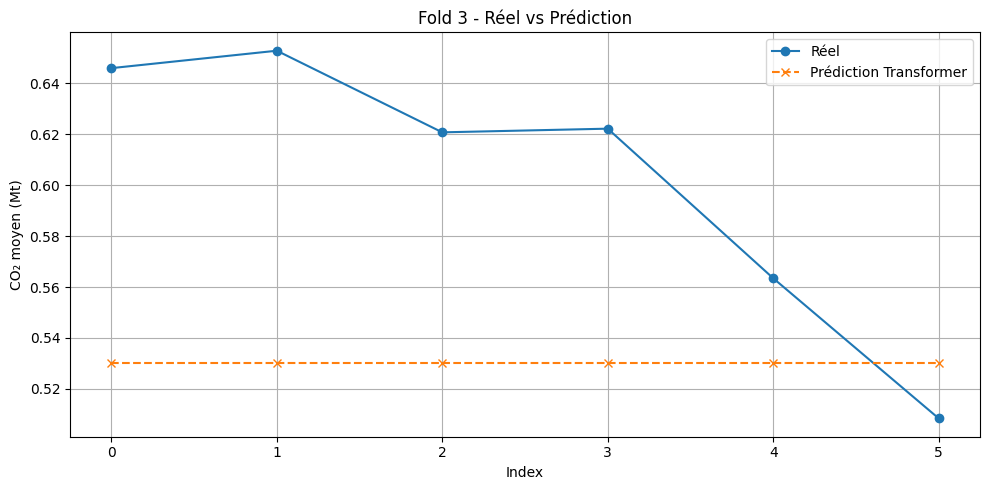

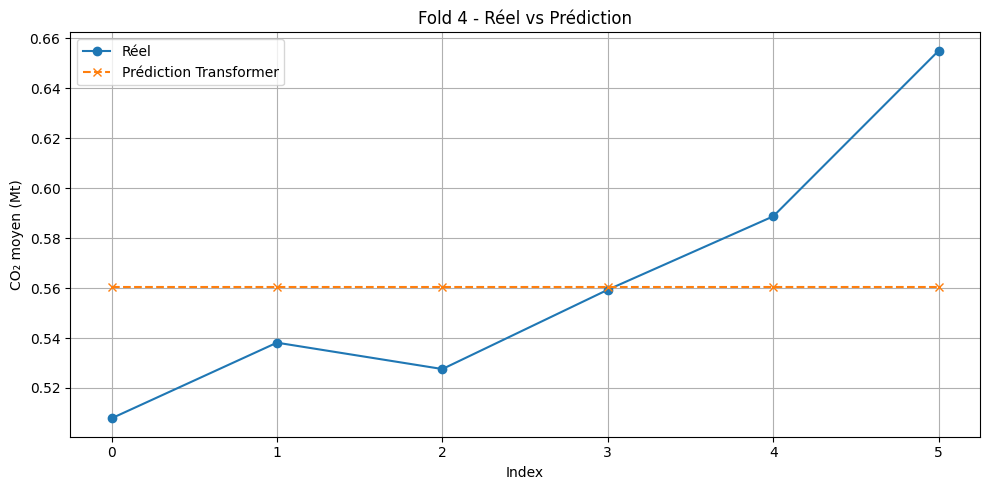

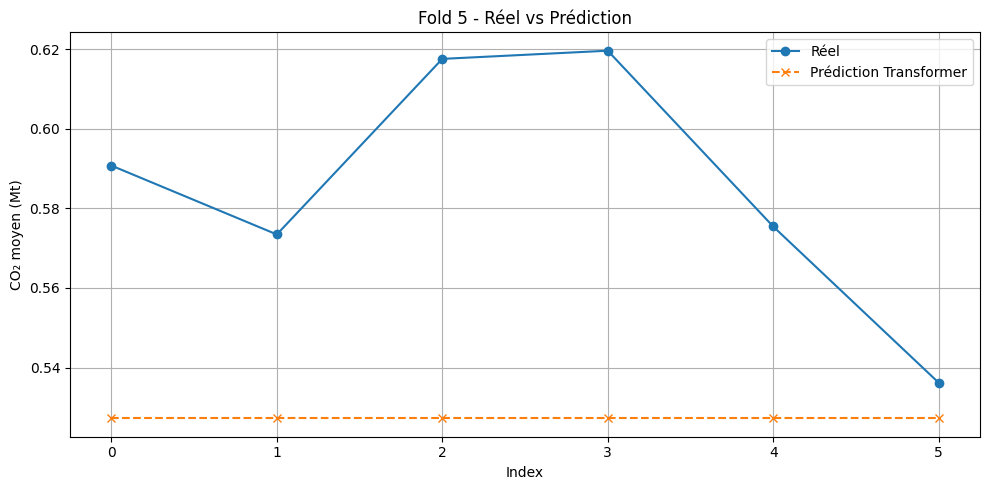


 Résumé des performances :
           MSE      RMSE       MAE        R2
Fold                                        
1     0.013725  0.117153  0.109733 -7.152523
2     0.006228  0.078915  0.050316 -0.533935
3     0.007804  0.088339  0.079433 -2.021324
4     0.002348  0.048454  0.038539 -0.002750
5     0.004209  0.064878  0.058253 -4.160133

 Moyennes :
MSE     0.006863
RMSE    0.079548
MAE     0.067255
R2     -2.774133
dtype: float64


In [26]:
# Modèle TARNSFORMER
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, GlobalAveragePooling1D, Add

#  Fonctions
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i + seq_length])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)

def build_transformer(seq_len, feature_dim, num_heads=2, ff_dim=32, dropout_rate=0.1):
    inputs = Input(shape=(seq_len, feature_dim))
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=feature_dim)(x, x)
    x = Add()([attn, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)
    ff = Dense(ff_dim, activation='relu')(x)
    x = Add()([Dense(feature_dim)(ff), x])
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

def compute_metrics(y_true, y_pred):
    return {
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

def plot_predictions(y_true, y_pred, fold):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label="Réel", marker='o')
    plt.plot(y_pred, label="Prédiction Transformer", linestyle='--', marker='x')
    plt.title(f"Fold {fold} - Réel vs Prédiction")
    plt.xlabel("Index")
    plt.ylabel("CO₂ moyen (Mt)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Chargement et préparation des données
df = pd.read_csv("dataset_preprocessed.csv", parse_dates=['date'])
df_monthly = df.resample('M', on='date')['value'].mean().reset_index()

scaler = MinMaxScaler()
df_monthly['value_scaled'] = scaler.fit_transform(df_monthly[['value']])

SEQ_LENGTH = 12
X, y = create_sequences(df_monthly['value_scaled'].values, SEQ_LENGTH)

#  Validation croisée
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
results = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    X_train = np.expand_dims(X_train, axis=-1)
    X_val = np.expand_dims(X_val, axis=-1)

    try:
        model = build_transformer(seq_len=SEQ_LENGTH, feature_dim=1)
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

        y_pred = model.predict(X_val, verbose=0).flatten()

        y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
        y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

        metrics = compute_metrics(y_val_inv, y_pred_inv)
        metrics['Fold'] = fold
        results.append(metrics)

        plot_predictions(y_val_inv, y_pred_inv, fold)

    except Exception as e:
        print(f"Erreur au fold {fold}: {e}")

#  Résultats
df_results = pd.DataFrame(results).set_index('Fold')

print("\n Résumé des performances :")
print(df_results)

print("\n Moyennes :")
print(df_results.mean())


df_transformer = df_results.copy()


In [33]:

#  Ajout d'une colonne pour identifier chaque modèle
df_arima['Modèle'] = 'ARIMA'
df_sarima['Modèle'] = 'SARIMA'
df_lstm['Modèle'] = 'LSTM'
df_transformer['Modèle'] = 'Transformer'

# Regroupage des résultats
df_all = pd.concat([df_arima, df_sarima, df_lstm, df_transformer], ignore_index=True)

#  Calcul moyenne des métriques par modèle
df_summary = df_all.groupby('Modèle', as_index=False).mean(numeric_only=True)

print("\n Moyenne des métriques par modèle :")
print(df_summary)





 Moyenne des métriques par modèle :
        Modèle       MSE      RMSE       MAE        R2
0        ARIMA  0.013089  0.102068  0.089579 -3.285892
1         LSTM  0.002513  0.048574  0.043272 -0.118319
2       SARIMA  0.002001  0.043302  0.037178 -0.006704
3  Transformer  0.006863  0.079548  0.067255 -2.774133


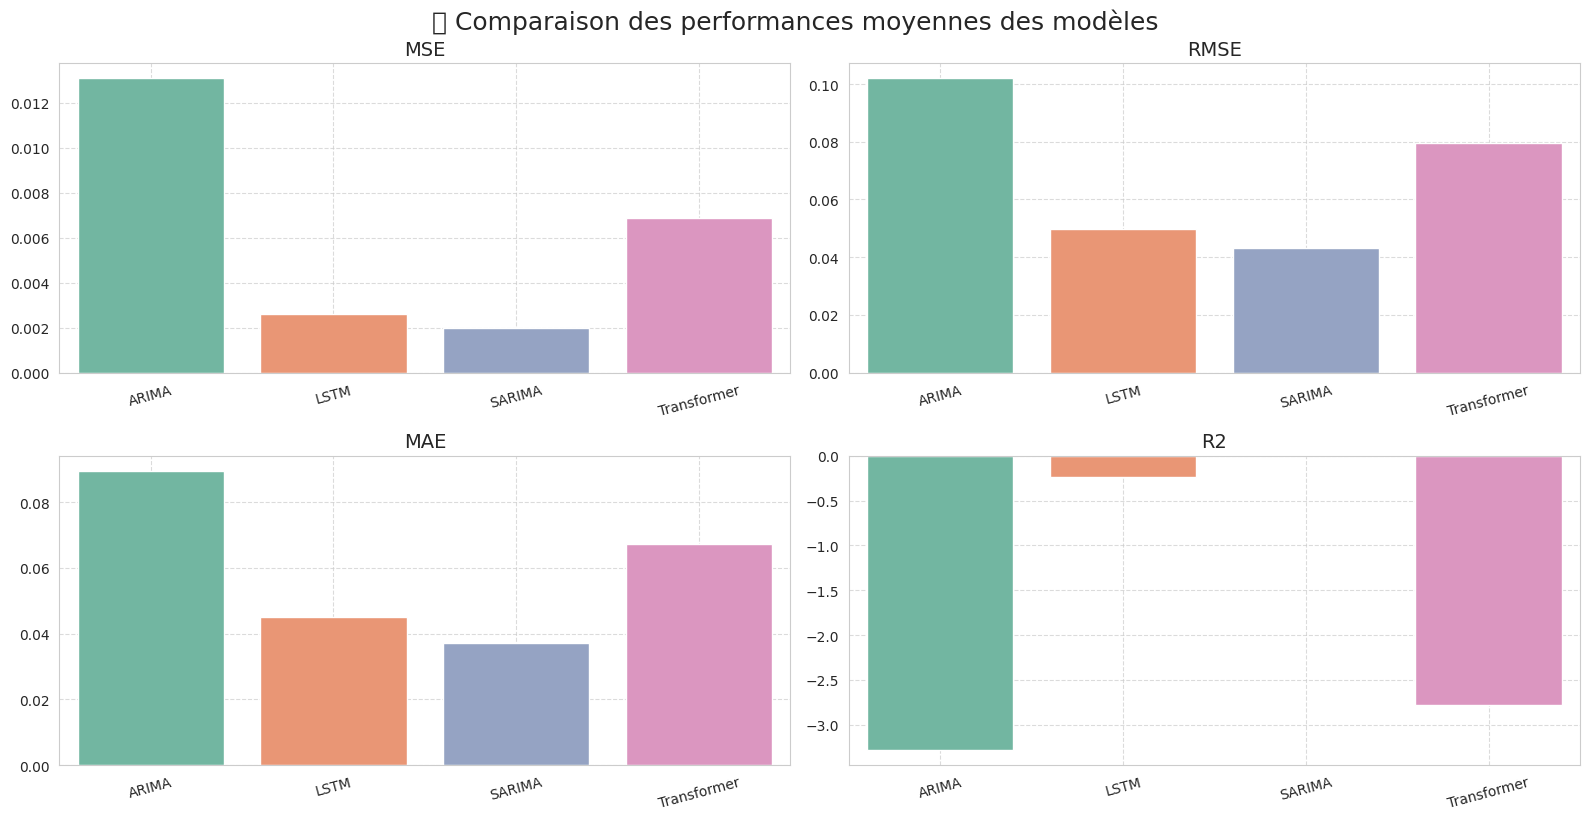

In [31]:

#  Style esthétique
sns.set_style('whitegrid')
palette = sns.color_palette('Set2')

#  Visualisation des performances
metrics = ['MSE', 'RMSE', 'MAE', 'R2']

plt.figure(figsize=(16, 8))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.barplot(data=df_summary, x='Modèle', y=metric, palette=palette)
    plt.title(f'{metric}', fontsize=14)
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(rotation=15)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

plt.suptitle("🔍 Comparaison des performances moyennes des modèles", fontsize=18, y=1.02)
plt.savefig("comparaison_modeles.png", dpi=300, bbox_inches='tight')
plt.show()


<ipython-input-16-4d1cfa0b025e>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M', on='date')['value'].mean().reset_index()
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py

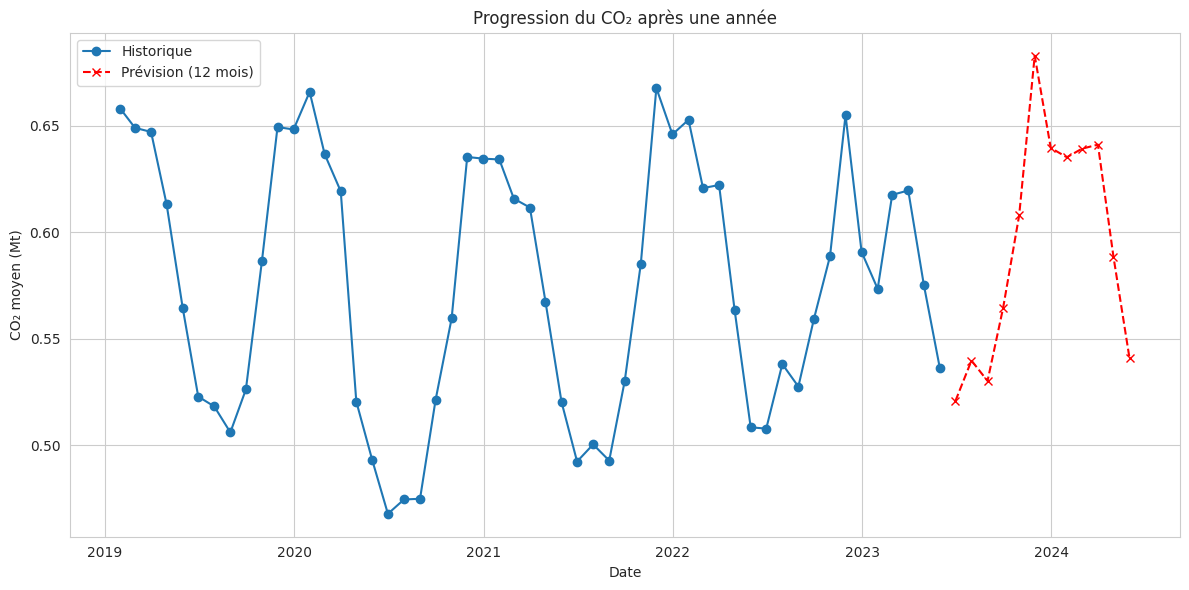

In [16]:
#  Chargement des donnes
df = pd.read_csv("dataset_preprocessed.csv", parse_dates=['date'])
df_monthly = df.resample('M', on='date')['value'].mean().reset_index()

#  Préparation de la série complète
y = df_monthly['value']

#  Entraînement sur tout l'historique
p, d, q = 1, 1, 1
P, D, Q, S = 1, 1, 1, 12

model = sm.tsa.SARIMAX(y, order=(p, d, q), seasonal_order=(P, D, Q, S))
model_fit = model.fit()

#  prédiction pour 12 mois futurs
n_steps = 12
forecast = model_fit.forecast(steps=n_steps)

#  index de dates futures
last_date = df_monthly['date'].iloc[-1]
future_dates = pd.date_range(last_date + pd.offsets.MonthBegin(1), periods=n_steps, freq='M')

#  Visualisation
plt.figure(figsize=(12, 6))
plt.plot(df_monthly['date'], df_monthly['value'], label='Historique', marker='o')
plt.plot(future_dates, forecast, label='Prévision (12 mois)', linestyle='--', marker='x', color='red')
plt.title('Progression du CO₂ après une année')
plt.xlabel('Date')
plt.ylabel('CO₂ moyen (Mt)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("projection_sarima.png", dpi=300, bbox_inches='tight')
plt.show()
